<a href="https://colab.research.google.com/github/nk2000/HSE_AML_Class1/blob/master/Week2/2_intro_to_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/HSE_AML/intro-to-dl/week2/v2")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import sys
FilePath = '/content/drive/My Drive/HSE_AML/intro-to-dl'
sys.path.append(FilePath)

# Intro to TensorFlow

This notebook covers the basics of TF and shows you an animation with gradient descent trajectory.
<img src="images/gradient_descent.png" style="width:50%">

# TensorBoard

**Plase note that if you are running on the Coursera platform, you won't be able to access the tensorboard instance due to the network setup there.**

Run `tensorboard --logdir=./tensorboard_logs --port=7007` in bash.

If you run the notebook locally, you should be able to access TensorBoard on http://127.0.0.1:7007/

In [3]:
import tensorflow as tf
import sys
sys.path.append("../..")
from keras_utils import reset_tf_session
s = reset_tf_session()
print("We're using TF", tf.__version__)

Using TensorFlow backend.


We're using TF 1.13.1


In [0]:
keras_utils.test()

Hello World!


In [0]:
!pip uninstall keras_utils

# Warming up
For starters, let's implement a python function that computes the sum of squares of numbers from 0 to N-1.

In [0]:
import numpy as np

def sum_python(N):
    return np.sum(np.arange(N)**2)

In [5]:
%%time
sum_python(10**5)

CPU times: user 916 µs, sys: 1.97 ms, total: 2.89 ms
Wall time: 2.3 ms


333328333350000

# Tensoflow teaser

Doing the very same thing

In [0]:
# An integer parameter
N = tf.placeholder('int64', name="input_to_your_function")

# A recipe on how to produce the same result
result = tf.reduce_sum(tf.range(N)**2)

In [7]:
# just a graph definition
result

<tf.Tensor 'Sum:0' shape=() dtype=int64>

In [8]:
%%time
# actually executing
result.eval({N: 10**5})

CPU times: user 7.33 ms, sys: 7.76 ms, total: 15.1 ms
Wall time: 39.1 ms


333328333350000

In [0]:
# logger for tensorboard
writer = tf.summary.FileWriter("tensorboard_logs", graph=s.graph)

# How does it work?
1. Define placeholders where you'll send inputs
2. Make a symbolic graph: a recipe for mathematical transformation of those placeholders
3. Compute outputs of your graph with particular values for each placeholder
  * `output.eval({placeholder: value})`
  * `s.run(output, {placeholder: value})`

So far there are two main entities: "placeholder" and "transformation" (operation output)
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be int32/64, floats, booleans (uint8) of various size.

* You can define new transformations as an arbitrary operation on placeholders and other transformations
 * `tf.reduce_sum(tf.arange(N)**2)` are 3 sequential transformations of placeholder `N`
 * There's a tensorflow symbolic version for every numpy function
   * `a+b, a/b, a**b, ...` behave just like in numpy
   * `np.mean` -> `tf.reduce_mean`
   * `np.arange` -> `tf.range`
   * `np.cumsum` -> `tf.cumsum`
   * If you can't find the operation you need, see the [docs](https://www.tensorflow.org/versions/r1.3/api_docs/python).
   
`tf.contrib` has many high-level features, may be worth a look.

In [0]:
with tf.name_scope("Placeholders_examples"):
    # Default placeholder that can be arbitrary float32
    # scalar, vertor, matrix, etc.
    arbitrary_input = tf.placeholder('float32')

    # Input vector of arbitrary length
    input_vector = tf.placeholder('float32', shape=(None,))

    # Input vector that _must_ have 10 elements and integer type
    fixed_vector = tf.placeholder('int32', shape=(10,))

    # Matrix of arbitrary n_rows and 15 columns
    # (e.g. a minibatch of your data table)
    input_matrix = tf.placeholder('float32', shape=(None, 15))
    
    # You can generally use None whenever you don't need a specific shape
    input1 = tf.placeholder('float64', shape=(None, 100, None))
    input2 = tf.placeholder('int32', shape=(None, None, 3, 224, 224))

    # elementwise multiplication
    double_the_vector = input_vector*2

    # elementwise cosine
    elementwise_cosine = tf.cos(input_vector)

    # difference between squared vector and vector itself plus one
    vector_squares = input_vector**2 - input_vector + 1

In [0]:
my_vector =  tf.placeholder('float32', shape=(None,), name="VECTOR_1")
my_vector2 = tf.placeholder('float32', shape=(None,))
my_transformation = my_vector * my_vector2 / (tf.sin(my_vector) + 1)

In [13]:
print(my_transformation)

Tensor("truediv:0", shape=(?,), dtype=float32)


In [14]:
dummy = np.arange(5).astype('float32')
print(dummy)
my_transformation.eval({my_vector: dummy, my_vector2: dummy[::-1]})

[0. 1. 2. 3. 4.]


array([0.       , 1.6291324, 2.0950115, 2.6289961, 0.       ],
      dtype=float32)

In [0]:
writer.add_graph(my_transformation.graph)
writer.flush()

TensorBoard allows writing scalars, images, audio, histogram. You can read more on tensorboard usage [here](https://www.tensorflow.org/get_started/graph_viz).

# Summary
* Tensorflow is based on computation graphs
* A graph consists of placeholders and transformations

# Loss function: Mean Squared Error

Loss function must be a part of the graph as well, so that we can do backpropagation.

In [0]:
with tf.name_scope("MSE"):
    y_true = tf.placeholder("float32", shape=(None,), name="y_true")
    y_predicted = tf.placeholder("float32", shape=(None,), name="y_predicted")
    # Implement MSE(y_true, y_predicted), use tf.reduce_mean(...)
    # mse = ### YOUR CODE HERE ###
    mse = tf.reduce_mean(tf.pow((y_true-y_predicted),2))
def compute_mse(vector1, vector2):
    return mse.eval({y_true: vector1, y_predicted: vector2})

In [0]:
writer.add_graph(mse.graph)
writer.flush()

In [0]:
# Rigorous local testing of MSE implementation
import sklearn.metrics
for n in [1, 5, 10, 10**3]:
    elems = [np.arange(n), np.arange(n, 0, -1), np.zeros(n),
             np.ones(n), np.random.random(n), np.random.randint(100, size=n)]
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(sklearn.metrics.mean_squared_error(el, el_2))
            my_mse = compute_mse(el, el_2)
            if not np.allclose(true_mse, my_mse):
                print('mse(%s,%s)' % (el, el_2))
                print("should be: %f, but your function returned %f" % (true_mse, my_mse))
                raise ValueError('Wrong result')

# Variables

Placeholder and transformation values are not stored in the graph once the execution is finished. This isn't too comfortable if you want your model to have parameters (e.g. network weights) that are always present, but can change their value over time.

Tensorflow solves this with `tf.Variable` objects.
* You can assign variable a value at any time in your graph
* Unlike placeholders, there's no need to explicitly pass values to variables when `s.run(...)`-ing
* You can use variables the same way you use transformations 
 

In [30]:
# Creating a shared variable
shared_vector_1 = tf.Variable(initial_value=np.ones(5),
                              name="example_variable")

Instructions for updating:
Colocations handled automatically by placer.


In [31]:
# Initialize variable(s) with initial values
s.run(tf.global_variables_initializer())

# Evaluating the shared variable
print("Initial value", s.run(shared_vector_1))

Initial value [1. 1. 1. 1. 1.]


In [32]:
# Setting a new value
s.run(shared_vector_1.assign(np.arange(5)))

# Getting that new value
print("New value", s.run(shared_vector_1))

New value [0. 1. 2. 3. 4.]


# tf.gradients - why graphs matter
* Tensorflow can compute derivatives and gradients automatically using the computation graph
* True to its name it can manage matrix derivatives
* Gradients are computed as a product of elementary derivatives via the chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

It can get you the derivative of any graph as long as it knows how to differentiate elementary operations

In [0]:
my_scalar = tf.placeholder('float32')

scalar_squared = my_scalar**2

# A derivative of scalar_squared by my_scalar
derivative = tf.gradients(scalar_squared, [my_scalar, ])

In [34]:
derivative

[<tf.Tensor 'gradients/pow_1_grad/Reshape:0' shape=<unknown> dtype=float32>]

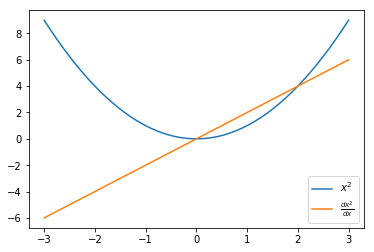

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-3, 3)
# Note: we can pass a list to a scalar placeholder, and it returns a ndarray corresponding result
x_squared, x_squared_der = s.run([scalar_squared, derivative[0]],
                                 {my_scalar:x})

plt.plot(x, x_squared,label="$x^2$")
plt.plot(x, x_squared_der, label=r"$\frac{dx^2}{dx}$")
plt.legend();

In [38]:
type(x_squared_der)

numpy.ndarray

# Why that rocks

In [39]:
my_vector = tf.placeholder('float32', [None])
# Compute the gradient of the next weird function over my_scalar and my_vector
# Warning! Trying to understand the meaning of that function may result in permanent brain damage
weird_psychotic_function = tf.reduce_mean(
    (my_vector+my_scalar)**(1+tf.nn.moments(my_vector,[0])[1]) + 
    1./ tf.atan(my_scalar))/(my_scalar**2 + 1) + 0.01*tf.sin(
    2*my_scalar**1.5)*(tf.reduce_sum(my_vector)* my_scalar**2
                      )*tf.exp((my_scalar-4)**2)/(
    1+tf.exp((my_scalar-4)**2))*(1.-(tf.exp(-(my_scalar-4)**2)
                                    )/(1+tf.exp(-(my_scalar-4)**2)))**2

der_by_scalar = tf.gradients(weird_psychotic_function, my_scalar)
der_by_vector = tf.gradients(weird_psychotic_function, my_vector)

Instructions for updating:
Use tf.cast instead.


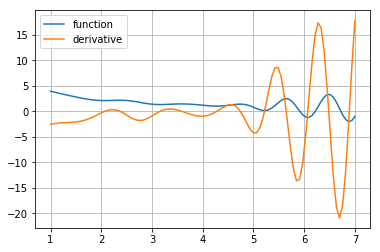

In [40]:
# Plotting the derivative
scalar_space = np.linspace(1, 7, 100)

y = [s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y, label='function')

y_der_by_scalar = [s.run(der_by_scalar,
                         {my_scalar:x, my_vector:[1, 2, 3]})
                   for x in scalar_space]

plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend();

# Almost done - optimizers

While you can perform gradient descent by hand with automatic gradients from above, tensorflow also has some optimization methods implemented for you. Recall momentum & rmsprop?

In [0]:
y_guess = tf.Variable(np.zeros(2, dtype='float32'))
y_true = tf.range(1, 3, dtype='float32')

loss = tf.reduce_mean((y_guess - y_true + 0.5*tf.random_normal([2]))**2) 

step = tf.train.MomentumOptimizer(0.03, 0.5).minimize(loss, var_list=y_guess)

In [42]:
y_true.eval()

array([1., 2.], dtype=float32)

Let's draw a trajectory of a gradient descent in 2D

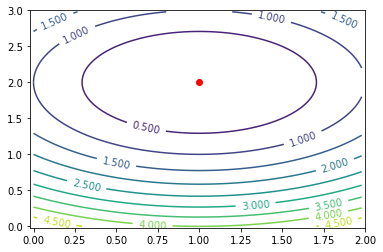

In [47]:
from matplotlib import animation, rc
import matplotlib_utils
from IPython.display import HTML, display_html

# nice figure settings
fig, ax = plt.subplots()
y_true_value = s.run(y_true)
level_x = np.arange(0, 2, 0.02)
level_y = np.arange(0, 3, 0.02)
X, Y = np.meshgrid(level_x, level_y)
Z = (X - y_true_value[0])**2 + (Y - y_true_value[1])**2
ax.set_xlim(-0.02, 2)
ax.set_ylim(-0.02, 3)
s.run(tf.global_variables_initializer())
ax.scatter(*s.run(y_true), c='red')
contour = ax.contour(X, Y, Z, 10)
ax.clabel(contour, inline=1, fontsize=10)
line, = ax.plot([], [], lw=2)

# start animation with empty trajectory
def init():
    line.set_data([], [])
    return (line,)

trajectory = [s.run(y_guess)]

# one animation step (make one GD step)
def animate(i):
    s.run(step)
    trajectory.append(s.run(y_guess))
    line.set_data(*zip(*trajectory))
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

In [46]:
X

array([[0.  , 0.02, 0.04, ..., 1.94, 1.96, 1.98],
       [0.  , 0.02, 0.04, ..., 1.94, 1.96, 1.98],
       [0.  , 0.02, 0.04, ..., 1.94, 1.96, 1.98],
       ...,
       [0.  , 0.02, 0.04, ..., 1.94, 1.96, 1.98],
       [0.  , 0.02, 0.04, ..., 1.94, 1.96, 1.98],
       [0.  , 0.02, 0.04, ..., 1.94, 1.96, 1.98]])

In [44]:
try:
    display_html(HTML(anim.to_html5_video()))
except (RuntimeError, KeyError):
    # In case the build-in renderers are unaviable, fall back to
    # a custom one, that doesn't require external libraries
    anim.save(None, writer=matplotlib_utils.SimpleMovieWriter(0.001))

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABOg21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MyBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAADJUZYiE
AC///vau/MsrRwuVLh1Ze7NR8uhJcv2IMH1oAAADAADVayF8oYJVUBjg5Cl8UC950wnQObmxLpMS
eTd2N1o7ZvU7nZLqidQWs9IRqH4qZFuUNOvgrgAArGB7WlESNB735J/CfrjEy3i5zjzWx5r7oD4b
7vRGf5YZpSE2SfCltWRnqtLPBS3FxRjhpp/BEdar5txSfEu67R/ppgZwAi2i8ff512MwmU2ndVwZ
0/IypwbXeLiexIGKwjGLSLtuFQ6Y/OKysfXRdbpNhUrKtfRj7PsZ4sEuP5y4zl61S+z6VZzYCdA7
422O/g7ogLDysqUE24GpHGaJCX2wbS68ujTHQP6XxiSrNlnDwZHgbp5EeVkCuMJlhlbRejAAAW5E
i95ObYO5PsuB/yXJXIr296w2R4KtEWts2QxCeaTyILNtSj0FAa6n+Sm+7xuX2JriZx97d2rE/cAU
Qsh/+Ymis26EZW9S/cjgVqTEtyVS3CIlK2Ezdp99jK7/nX0GHUivuh8QdJ4bhVPEmo5B7TQYe9Nv
n+ebyMRkTx7hvj05vOEfMTes/dwPLUI91WSm8NQ11fuo1LrBS7pJhE73vxY1JjcZWnegaFLpPjAo
+BqceCYe5S3Av97ANnEBmzojm/SDmWarQluOhREg6XGZMu4a7snjhzyH4/KonlxVMyXTB8Ya3dGT
vrxM2T8GRxsFP+Ki2XIeafZhzaICPKgU1x2LYZqQc9bRDlrWDpuTNmcCbrO7DXBPWt4+vc4y9j41
N3ttOlZHSj7BLRUyn3jQ7SaqbIIfathMr5UyLG2sIhgEVnH/ucB0hSCdaRR7tfjt4u8PvhnTQjOr
XFuMq9D+ai7PeOXVVnhjRUG1NlE+qvV7AEI5G7TdDi3Ot79+th04S+yL6kitI1paTBiMcHTxpn5X
LBkmi7PWbDvDmg5lJAHwROy2oJRfUYjaQw3SAnY7FAERErAGIDBqqPQJaFyjGd6y15L/A4RQE90w
26aJjRd6LiA50nY4ySvCZLA7zrAL53hpoxCwgW6XRvxgLia4L4hYOh3gf0IUhPaJ3G3bd8XpFjL2
+h/vvhmyJo/GBlrOzeAVUV/uX2KIRw2tSA4lpY7HRLqTs9WK8UBppmkFMjiRn2ZuSYkUBfizN6PB
9HMOtuBHNkzy5IeyqUfJ2ROw0QtO3a1al0U4xq2CypxPOHRYS6A+QB/ByUoi0qfhrx6E02xA7iTP
5QTGTxgLQBmCInEdpSYX7K2+HpwAJPY6whtp6txK2t7LsYi8XuE9mrqJA+ndpoqCogHnXMm5SU+U
98sP2yWQGbuSA5sLW+Bsm/v5ZbCFnkMTkZR89QTm+rh5boNsP/4E4kPm/3qG7BC5wO+Ec3HPSWKm
NGeaXCd7Th4DBC9DSkgcA7cg9XN1u/on2zYZEMM+UYaDkdXa+hdlBmxgU0brmHXBVaaPS4ue3N5Y
hH7lEWh9YhGOa1FfO9DbPCDHOyLyV2yH1Cg0lpTc8nJdutqYrxU0eUmJs3SXPp7v9ZFRt0LuQ+Hu
hfuXSBIvboY0wgOOwwFFb/dKjCGFW5j9MyMA0fbF4QkX7xcrHymw6YOZNarOOfTRsLMi3ig+IIvX
K3LwlIQdmQA5eSSyp0Es5h4bFxAyabuitHDKQBfYURKB9NiuhgaKoiSwK9n4Jr5hTHhlYEnXuAjD
Hn2efoK+Beq189O9V7r5zDX6ZY4NBQiuuNOLdjBJdC4avvxDBNXiXBf88Ng0IQKGQOYunJWHbF+R
NUMAl7MuEJZshqWTF3Zn9GQb0ek+gbbQk+Q/pfGpC5htdjsepo2Mq+E45GKYmA1gGAcGWDWqNpS6
dldXZAKwybJ+ASKADBjW8WN35MCAhjboYxEARsfRT/Ohl6gKuvdk2azvrCs7nlgu35yOjUF38izI
WFgh6FSK/7HLAnqr0I9PgSHUTGlbFGCbEg/IibtYsmUmgcq2WAAuAByYr7BwvJ9U0ZXkpmk3qRBA
hm+KwYtIL8WSEt7Y6V77bcrXIPTJWs+5lld5D0hNRvw4ABikvwMbXZZR8mUZgesu05bpx0BrJVAg
cDTCRKpJsww2LguA6ojO7Gu0oNJrz8smX+ibmnTXSXxzrCcSjNOOsuFSt9xBiyMuxlOFY1EMSt2F
zVZj+0wHpkgtc7wzQ6Bn+ln1ynMcFVwzc9qY/Rf6UnYdMlk+mwBtA2WBtA0SVK4LndRBdQiOpkGH
0fMkE3oWxyLoITilH62y6deLmwFyEWLHXvQxfjWaqAdBpG+tiYAr/ii/jr++ZnRL25mtQnnFfB/1
s1l7hp2+EgMlSTiAtH6opXJVtMbtXBPj8+UEvVLned1NjYR43bYQQuTzhYxOK6FRyoFpX6xh2WU0
ANyELjzkC1ErbKIZg+iBrIOjQWoyguFgssSTDxJY7HQ0F423V4XJk2747L7UOl3Dmt950C2uJVmM
TXwbq3QhaWQ9IfkpQCdxULhZgf8sZgMv1McudnBAewNdNXHIDh+SG6WY8MFa8nLdhaX0cd++NVe7
DDBcBoaOe24CsCWGDoOjRkycML/kqpi3BUjOiBBKosalALVQDTjbCX0aDhLqZ070mrqsyH1mU4QK
rl4wgXmd3vcuW9N0qbkdUhj7FxRU3zTdBTE739imhoFHsL4LIJtUlTLx0JGFZO/lkECK8bDHaTQw
UCD2idUIgBqDB4uD9BpSaSPdkkrUsrTnvIC5PrcG4lCYg+0AVBVFusaADpGhg4Z7TFhi9Vc9Atsv
YBEXnKShOdH9Fo2/8IIm03MlEuLvqYtGxJlbpfHMxq1oj/C1cikAtkfItVaVqfW+kfNtE647d7b5
xnG0hTY9fwc/PDfcXgSEwamXA5rX1TOu0hHtd9IkTF/6R20C7N/cLMIC3KfPedssAsgHncq4oyET
g/WBYiqAEXVK7OM7ktAiY